# **Spam Likely | An Email Spam Classifier**

#### By Jackson Trader, Diego Lara, Mark Pack, & Alex Bryant
#### CS 46200 - Introduction To Artificial Intelligence

##### [Spam Email Classification Dataset from Kaggle](https://www.kaggle.com/datasets/ashfakyeafi/spam-email-classification)

##### [Unseen Dataset from Kaggle](https://www.kaggle.com/datasets/devildyno/email-spam-or-not-classification)

---

## **Import Libraries**

In [170]:
# NumPy and Pandas libraries for numerical computing and organizing data respectively
import numpy as np
import pandas as pd

# Matplotlib and WordCloud for data visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Used to split data into training and testing sets
from sklearn.model_selection import train_test_split

# For converting text (messages) into number vectors
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning models we will use:
# Baseline Algorithms for this project -> Logistic Regression, Multinomial Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC # LinearSVC because TF-IDF feature vectors have high dimensionality

# For evaluating performance of the models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## **Load the Dataset**

In [171]:
# Loading the dataset into a Pandas DataFrame object
df = pd.read_csv("email_spam_data.csv")

## **View the Dataset**

In [172]:
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Count Columns & Ratio Between Ham vs. Spam Emails

In [173]:
print("Columns of dataset:")
print(df.columns.tolist())

print("\nRatios between ham (legit) vs. spam respectively: ")
print(df['Category'].value_counts().tolist())

Columns of dataset:
['Category', 'Message']

Ratios between ham (legit) vs. spam respectively: 
[4825, 747]


The dataset contains 5572 rows of data and 2 columns: Category & Message <br>
The dataset is unbalanced: 4825 ham (legit) : 747 spam



## **Preprocess the Data**

### Remove Missing Values

In [174]:
# Removes rows where either Category or Message is missing
df = df.dropna(subset = ['Category', 'Message'])

### Remove Duplicate Rows

In [175]:
df = df.drop_duplicates()

### Fix Indexing of DataFrame After Removing Values / Rows

In [176]:
df.reset_index(drop = True, inplace = True)

### Change Category Titles (ham = 0, spam = 1)

In [177]:
df['Category'] = df['Category'].map({
    'ham': 0, # legit
    'spam': 1
})

### Remove Whitespace in Beginning and End

In [178]:
df['Message'] = df['Message'].astype(str) # As type incase message is just numbers
df['Message'] = df['Message'].str.strip() # Remove whitespace in beginning and end of each message

We have an ablation study on lowercasing vs. not lowercasing the messages in the dataset. So we have chosen to not lowercase the messages, because we believe scammers place emphasis on scammy words like FREE or CALL for example.

### View Dataset Again

In [179]:
df

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5152,1,This is the 2nd time we have tried 2 contact u...
5153,0,Will ü b going to esplanade fr home?
5154,0,"Pity, * was in mood for that. So...any other s..."
5155,0,The guy did some bitching but I acted like i'd...


After preprocessing, we now have 5157 rows of data.

Small tip: Category and Message are headers and are not counted as rows.

## **Data Visualization**

### Pie Chart of Ratio of Spam vs. Legit Emails

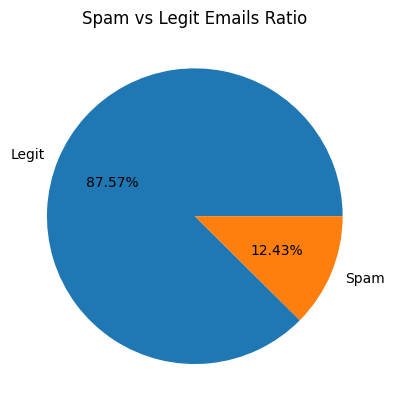

In [180]:
counts = df['Category'].value_counts()
counts.index = counts.index.map({1: 'Spam', 0: 'Legit'})

counts.plot(kind = 'pie', autopct = '%1.2f%%')
plt.ylabel('')
plt.title("Spam vs Legit Emails Ratio")

# Show the Pie Chart
plt.show()

As you can see, the data is unbalanced.

### WordCloud of Most Common Words in Spam vs. Legit

In [181]:
# Concatenate messages together for each category
spam_text = "".join(df.loc[df['Category'] == 1, 'Message'].astype(str))
legit_text = "".join(df.loc[df['Category'] == 0, 'Message'].astype(str))

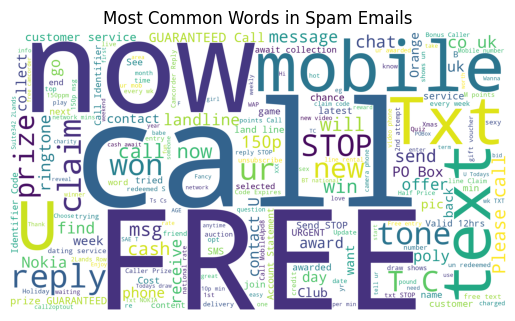

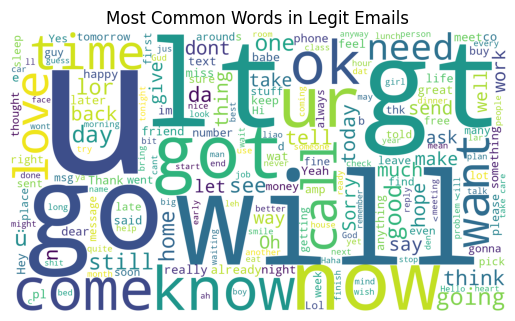

In [182]:
# Spam WordCloud
wordcloud = WordCloud(
    width = 1920,
    height = 1080,
    background_color = 'white',
    stopwords = STOPWORDS,
).generate(spam_text)
plt.title("Most Common Words in Spam Emails")
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Legit WordCloud
wordcloud = WordCloud(
    width = 1920,
    height = 1080,
    background_color = 'white',
    stopwords = STOPWORDS,
).generate(legit_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most Common Words in Legit Emails")
plt.show()


Here are the most common words in both categories of the emails. Pretty cool.

## **Split the Data**

Splitting the data into a train and test sets: <br>
* Train set contains 80% of data.
* Test set contains 20% of data.

In [183]:
X = df['Message'] # Independent variable
y = df['Category'] # Dependent variable (What we are predicting)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2, # 20% test data
    random_state = 100, # For reproducability so you can compare with graphs in the final report
    stratify = y # Preserve ratio distribution after splitting data into sets
)

print("Training set size (80%): ", X_train.shape[0])
print("Testing set size (20%): ", X_test.shape[0])

Training set size (80%):  4125
Testing set size (20%):  1032


These are ratios compared to the num of rows of the dataset: <br>
*   4125 / 5157 is about 80%
*   1032 / 5157 is about 20%




## **Feature Extraction**

Using TF-IDF (Term Frequency-Inverse Document Frequency) because:
* It gives a higher importance (score) to words that appear often in a specific message, but appear few times in all of the messages.
* So, words that appear in few messages have a higher importance rather than words that appear in many messages basically.
* These importance 'scores' are in the returned in feature vectors full of numbers.

There were other options too like Bag-of-Words representation, maybe we can cover that in the future
Bag-of-words is similar but less complex, therefore we only chose IF-IDF for vectorization. Bag-of-Words just counts each occurence of a word in each message and stores the vocabulary frequency in a numerical feature vector.

In [184]:
# Transform the messages into numerical feature vectors that can be used as input to train the models

vectorizer = TfidfVectorizer(
    stop_words = 'english',
    lowercase = False
)

X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

We will experiment with 'ngram_range' in the next step for our ablation study coming up!<br> It is a hyperparameter of the TfidfVectorizer, given by Scikit-learn's library.<br> To see if more context of words leads to better results.

## **Train the Baseline Models**

These are our baseline algorithms because they are more popular in the data science world. We also learned about them our lectures, whereas Linear Support Machines were not included in our lectures, or just don't recall it be discussed about.

### Logistic Regression

In [185]:
lr = LogisticRegression()

# Training the Logistic Regression model with the training data
lr.fit(X_train_features, y_train)

LogisticRegression()

### Multinomial Naive Bayes

In [186]:
mnb = MultinomialNB()

# Training the Multinomial Naive Bayes model with the training data
mnb.fit(X_train_features, y_train)

MultinomialNB()

## **Train the Primary Model**

### Linear Support Vector Classification

In [187]:
svc = LinearSVC()

# Training the LinearSVC model with the training data
svc.fit(X_train_features, y_train)

LinearSVC()

## **Scale Model Size & Complexity**

### Effects of Changing TF-IDF's 'ngram_range' Hyperparameter w/ LinearSVC

n-grams are groups of consecutive words that let the model you are training have more context when analzying text, rather than looking at each word independently.

Example:
*   2-gram -> ("claim", "your"), ("free", "car"), ...
*   3-gram -> ("claim", "your", "free"), ("car", "right", "now"), ...

Because we are using a range from 1 to #, 2-grams will include 1-grams, and 3-grams will include 1-grams and 2-grams. This expands the features of the vectorizer so it can have more context.



In [188]:
# Metrics list for many of our DataFrames
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

In [224]:
ngram_range_values = [(1, 1), (1, 2), (1, 3)] # 1-grams, 2-grams, 3-grams respectively
ngrams_table = []

for ngram_range in ngram_range_values:
  ngram_vectorizer = TfidfVectorizer(
    stop_words = 'english',
    ngram_range = ngram_range # Changing n-gram range here
  )

  X_train_ngrams_features = ngram_vectorizer.fit_transform(X_train)
  X_test_ngrams_features = ngram_vectorizer.transform(X_test)

  ngram_svc = LinearSVC()
  ngram_svc.fit(X_train_ngrams_features, y_train)

  ngram_svc_pred = ngram_svc.predict(X_test_ngrams_features)

  ngrams_table.append({
    "n-grams": str(ngram_range[1]) + "-grams",
    "Accuracy": accuracy_score(y_test, ngram_svc_pred) * 100,
    "Precision": precision_score(y_test, ngram_svc_pred) * 100,
    "Recall": recall_score(y_test, ngram_svc_pred) * 100,
    "F1 Score": f1_score(y_test, ngram_svc_pred) * 100,
  })

ngram_df = pd.DataFrame(ngrams_table)
ngram_df[metrics] = ngram_df[metrics].round(2)

ngram_df

,n-grams,Accuracy,Precision,Recall,F1 Score
0,1-grams,98.55,98.29,89.84,93.88
1,2-grams,98.55,98.29,89.84,93.88
2,3-grams,98.64,98.31,90.62,94.31


We are not sure why 1-grams and 2-grams have the same metrics. But, you can see that once we start considering 3-grams, our performance increases. This could increase our performance, but at what point does we start to have diminishing returns?

## **Ablation Study**

### Lowercases Text vs. Not Lowercasing Text

It is possible that not lowercasing text could have better accuracy, because scammers usually emphasize words like FREE or CLAIM in capital letters. Let's find out if that is true for our LinearSVC model.

In [190]:
ablation_lowercase_vectorizer = TfidfVectorizer(
  stop_words = 'english',
  lowercase = True
)

X_train_ablation_features = ablation_lowercase_vectorizer.fit_transform(X_train)
X_test_ablation_features = ablation_lowercase_vectorizer.transform(X_test)

ablation_svc = LinearSVC()
ablation_svc.fit(X_train_ablation_features, y_train)

ablation_svc_pred = ablation_svc.predict(X_test_ablation_features)

#### Bar Graph for Visualization

In [191]:
ablation_df = pd.DataFrame({
    'Ablation': [
      'Default',
      'Lowercase'
    ],

    'Accuracy': [
      accuracy_score(y_test, svc_pred),
      accuracy_score(y_test, ablation_svc_pred)
    ],
    'Precision': [
        precision_score(y_test, svc_pred),
        precision_score(y_test, ablation_svc_pred)
    ],
    'Recall': [
        recall_score(y_test, svc_pred),
        recall_score(y_test, ablation_svc_pred)
    ],
    'F1 Score': [
        f1_score(y_test, svc_pred),
        f1_score(y_test, ablation_svc_pred)
    ]
})

for metric in metrics:
  ablation_df[metric] = (ablation_df[metric] * 100).round(2)

# Show the ablation table
ablation_df


,Ablation,Accuracy,Precision,Recall,F1 Score
0,Default,98.45,96.67,90.62,93.55
1,Lowercase,98.55,98.29,89.84,93.88


Just because LinearSVC is our primary model that we are learning about for this project, and using Logistic Regression and Multinomial Naive Bayes as baseline models, we decided to only do the ablation study using LinearSVC on the dataset.

## **Evaluation Metrics of Baseline and Primary Models**

Each model gets evaluated on these metrics:
*   Accuracy
*   Precision
*   Recall
*   F1 Score
*   Confusion Matrix

### Evaluations of Baseline Models

#### Logistic Regression

In [192]:
lr_pred = lr.predict(X_test_features)

print("Logistic Regression")
print("Accuracy: " + str(round(accuracy_score(y_test, lr_pred) * 100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_test, lr_pred) * 100, 2)) + "%")
print("Recall: " + str(round(recall_score(y_test, lr_pred) * 100, 2)) + "%")
print("F1 Score: " + str(round(f1_score(y_test, lr_pred) * 100, 2)) + "%")

Logistic Regression
Accuracy: 95.06%
Precision: 96.39%
Recall: 62.5%
F1 Score: 75.83%


#### Multinomial Naive Bayes

In [193]:
mnb_pred = mnb.predict(X_test_features)

print("Multinomial Naive Bayes")
print("Accuracy: " + str(round(accuracy_score(y_test, mnb_pred) * 100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_test, mnb_pred) * 100, 2)) + "%")
print("Recall: " + str(round(recall_score(y_test, mnb_pred) * 100, 2)) + "%")
print("F1 Score: " + str(round(f1_score(y_test, mnb_pred) * 100, 2)) + "%")

Multinomial Naive Bayes
Accuracy: 96.22%
Precision: 100.0%
Recall: 69.53%
F1 Score: 82.03%


### Evaluation of Primary Model

#### LinearSVC

In [194]:
svc_pred = svc.predict(X_test_features)

print("LinearSVC")
print("Accuracy: " + str(round(accuracy_score(y_test, svc_pred) * 100, 2)) + "%")
print("Precision: " + str(round(precision_score(y_test, svc_pred) * 100, 2)) + "%")
print("Recall: " + str(round(recall_score(y_test, svc_pred) * 100, 2)) + "%")
print("F1 Score: " + str(round(f1_score(y_test, svc_pred) * 100, 2)) + "%")

LinearSVC
Accuracy: 98.45%
Precision: 96.67%
Recall: 90.62%
F1 Score: 93.55%


## **Comparing the Three Models**

*   Accuracy - How often the model is correct overall
*   Precision - How often is the prediction of spam actually spam
*   Recall - How many actual spam emails did the model find
*   F1 Score - Mean of precision and recall



### Metrics Comparison Table

In [195]:
comparison_df = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Multinomial Naive Bayes',
        'LinearSVC'
    ],

    'Accuracy': [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, mnb_pred),
        accuracy_score(y_test, svc_pred)
    ],
    'Precision': [
        precision_score(y_test, lr_pred),
        precision_score(y_test, mnb_pred),
        precision_score(y_test, svc_pred)
    ],
    'Recall': [
        recall_score(y_test, lr_pred),
        recall_score(y_test, mnb_pred),
        recall_score(y_test, svc_pred)
    ],
    'F1 Score': [
        f1_score(y_test, lr_pred),
        f1_score(y_test, mnb_pred),
        f1_score(y_test, svc_pred)
    ]
})

for metric in metrics:
  comparison_df[metric] = (comparison_df[metric] * 100).round(2)

# Show the comparison table
comparison_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,95.06,96.39,62.50,75.83
1,Multinomial Naive Bayes,96.22,100.00,69.53,82.03
2,LinearSVC,98.45,96.67,90.62,93.55


### Metrics Comparison Bar Chart

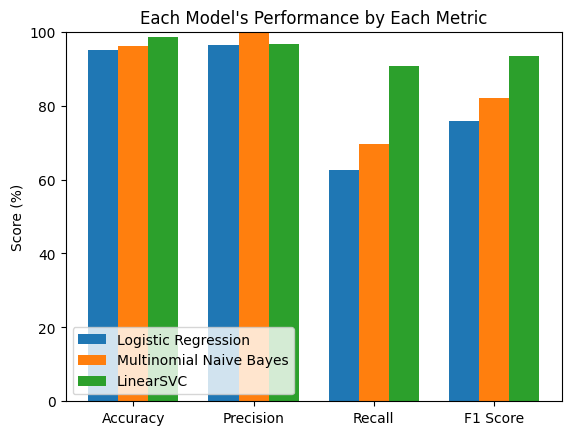

In [196]:
models = ['Logistic Regression', 'Multinomial Naive Bayes', 'LinearSVC']

x = np.arange(len(metrics)) # [0, 1, 2, 3]
width = 0.25 # Each bars width

for i, model in enumerate(models):
    values = comparison_df.loc[comparison_df['Model'] == model, metrics].values.flatten()
    plt.bar(x + (i - 1) * width, values, width, label = model)

plt.xticks(x, metrics)
plt.ylabel('Score (%)')
plt.title("Each Model's Performance by Each Metric")
plt.legend(loc = 'lower left')
plt.ylim(0, 100)

# Show the Bar Chart
plt.show()

As you can see, we are mostly looking at their Recall and F1 Score when evaluating each model, because Accuracy and Precision are very similar.

### Comparison Summary



Logistic Regression performed the worst out of the three models. It the lowest accuracy, precision, recall, and F1 score.

Multinomial Naive Bayes achieved perfect precision and better results than Logistic Regression.

LinearSVC was produced the best overall performance, even though the precision was less than Multinomial Naive Bayes. It achieved the highest accuracy, recall and F1 score.

### Which Model Performed the Best?

We believe that LinearSVC is the best general purpose model for classifying emails as spam or legit, from the comparisons we have done on the three models in this project. It achieved the best scores other than precision, making it a highly efficient model for classification.

## **Testing on a Few Unseen Emails & Pseudo Copies**

### Using an Unseen Dataset from Kaggle

In [204]:
# Loading the unseen dataset into a Pandas DataFrame object
unseen_df = pd.read_csv("unseen_email_spam_data.csv")
unseen_df

,message_content,is_spam
0,"Hello Lonnie,\n\nJust wanted to touch base reg...",0
1,"Congratulations, you've won a prize! Call us n...",1
2,You have been pre-approved for a credit card w...,1
3,"Limited time offer, act now! Only a few spots ...",1
4,Your loan has been approved! Transfer funds to...,1
...,...,...
995,"Hello Virginia,\n\nIt was great to catch up wi...",0
996,Final notice: Claim your inheritance from a di...,1
997,Hot singles in your area want to chat! Contact...,1
998,Your loan has been approved! Transfer funds to...,1


In [220]:
# Data wrangling to make it look like other dataset
unseen_df = unseen_df.rename(columns={
    'is_spam': 'Category',
    'message_content': 'Message'
})

# Swap columns
unseen_df = unseen_df[['Category', 'Message']]

unseen_df = unseen_df.drop_duplicates()
unseen_df = unseen_df.dropna(subset = ['Category', 'Message'])
unseen_df.reset_index(drop = True, inplace = True)

unseen_df

,Category,Message
0,0,"Hello Lonnie,\n\nJust wanted to touch base reg..."
1,1,"Congratulations, you've won a prize! Call us n..."
2,1,You have been pre-approved for a credit card w...
3,1,"Limited time offer, act now! Only a few spots ..."
4,1,Your loan has been approved! Transfer funds to...
...,...,...
672,0,"Hi Brandon,\n\nI hope this message finds you w..."
673,0,"Dear Wesley,\n\nI wanted to let you know about..."
674,0,"Hello Virginia,\n\nIt was great to catch up wi..."
675,1,Hot singles in your area want to chat! Contact...


As you can see, we have 677 rows of unseen data we will test on.

In [226]:
# Running messages through the same vectorizer as the one we used for the other dataset
X_unseen = vectorizer.transform(unseen_df["Message"])
y_unseen = unseen_df["Category"] # What we are trying to predict

unseen_pred = svc.predict(X_unseen)

print("LinearSVC on Unseen Data")
print("Accuracy:", round(accuracy_score(y_unseen, unseen_pred) * 100, 2), "%")
print("Precision:", round(precision_score(y_unseen, unseen_pred, zero_division=0) * 100, 2), "%")
print("Recall:", round(recall_score(y_unseen, unseen_pred, zero_division=0) * 100, 2), "%")
print("F1 Score:", round(f1_score(y_unseen, unseen_pred, zero_division=0) * 100, 2), "%")

LinearSVC on Unseen Data
Accuracy: 83.9 %
Precision: 100.0 %
Recall: 38.42 %
F1 Score: 55.51 %


As you can see the Accuracy and Precision remain somewhat high, but Recall and F1 Score are low. Giving this email classifier more sets of data that is unique would help make this classifer more efficient in general.

### Using LLMs, We Also Paraphrased Existing Emails From the Dataset

In [197]:
# Function for testing new emails

model_associations = {
    "Logistic Regression" : lr,
    "Multinomial Naive Bayes" : mnb,
    "LinearSVC" : svc
}

def test_emails(unseen_emails):
  for true_category, message in unseen_emails:
    features = vectorizer.transform([message])

    print("\n\nEmail: " + message + "\nTrue Category: " + true_category + "\n")

    for name, model in model_associations.items():
      prediction = model.predict(features)[0]

      if prediction == 1:
        print(name + " Prediction: spam")
      else:
        print(name + " Prediction: legit")

Paraphrased from these emails in the dataset using LLMs:

Spam Emails
*   07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow
*   Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!

Legit Emails
*   Sorry, I'll call later in meeting
*   Your gonna have to pick up a $1 burger for yourself on your way home. I can't even move. Pain is killing me.


In [199]:
paraphrased_emails= [
    ("spam", "We attempted to reach you regarding your response about the free Nokia phone and camcorder. Call 08000930705 now to arrange delivery for tomorrow."),
    ("spam", "Congratulations! You’ve been selected to receive a one-year cinema pass for two people. Call 09061209465 today to claim your free offer before it expires."),
    ("legit", "Apologies, I’m currently in a meeting and will call you back later."),
    ("legit", "You’ll need to grab yourself a one-dollar burger on the way home. I’m in too much pain to get up right now.")
]

test_emails(paraphrased_emails)



Email: We attempted to reach you regarding your response about the free Nokia phone and camcorder. Call 08000930705 now to arrange delivery for tomorrow.
True Category: spam

Logistic Regression Prediction: legit
Multinomial Naive Bayes Prediction: legit
LinearSVC Prediction: spam


Email: Congratulations! You’ve been selected to receive a one-year cinema pass for two people. Call 09061209465 today to claim your free offer before it expires.
True Category: spam

Logistic Regression Prediction: spam
Multinomial Naive Bayes Prediction: legit
LinearSVC Prediction: spam


Email: Apologies, I’m currently in a meeting and will call you back later.
True Category: legit

Logistic Regression Prediction: legit
Multinomial Naive Bayes Prediction: legit
LinearSVC Prediction: legit


Email: You’ll need to grab yourself a one-dollar burger on the way home. I’m in too much pain to get up right now.
True Category: legit

Logistic Regression Prediction: legit
Multinomial Naive Bayes Prediction: legit

Again, sometimes the models cannot classify the email correctly still. There is plenty of room for improvements. To prove that, Gmail and other big companies still have spam emails getting through their filters. But, if we work on this project again in the future I am sure there can be many small improvements.

## **Try it Out Yourself**

### Defining the Email Classifer Function

In [200]:
def classify_email(message, model_chosen):
  features = vectorizer.transform([message])

  model_chosen = model_chosen.lower()

  if model_chosen == "lr":
    prediction = lr.predict(features)[0]
  elif model_chosen == "nb":
    prediction = mnb.predict(features)[0]
  elif model_chosen == "svc":
    prediction = svc.predict(features)[0]
  else:
    return "Invalid model chosen"

  if prediction == 1:
    return "spam"
  else:
    return "legit"

### Try it Out With Your Own Message

**Some email examples to try out:**

Spam Emails
*   Congratulations! You have won a 1,000 dollar gift card. Click the link below to claim your prize now.
*   Limited time offer!!! No experience required. Sign up today. Earn 100,000 dollars in cash!

Legit Emails
*   Can you review the attached document and send feedback by Friday?
*   Free pizza in the lounge room for everyone attending the group meeting.



In [201]:
model_chosen = input("Which model would you like to use? (lr, nb, svc):\n")
message = input("\nPut your email message here to classify:\n")

result = classify_email(message, model_chosen)

if result == "Invalid model chosen":
  print("\n" + result)
else:
  print("\nThis is a " + result + " email.")

Which model would you like to use? (lr, nb, svc):
svc

Put your email message here to classify:
blah

This is a legit email.
